Loading datasets...
 Datasets loaded successfully
Dataset1 shape: (907, 12)
Dataset2 shape: (2123, 7)

DATA CLEANING - dataset1
Converting time columns...
Removed 0 rows with missing critical values
Removed 1 duplicate rows
Final cleaned dataset size: (906, 12)

CORRECTED FEATURE ENGINEERING
Features created:
- immediate_rat_presence: {False: 814, True: 92}
- time_category: {'1-5min': 424, '5-10min': 201, '0-1min': 154, '10+min': 127}

Sample data verification:


,seconds_after_rat_arrival,immediate_rat_presence,time_category
0,108,False,1-5min
1,17,True,0-1min
2,41,False,0-1min
3,111,False,1-5min
4,194,False,1-5min
5,215,False,1-5min



ANALYSIS 1: VIGILANCE BY TIME SINCE RAT ARRIVAL


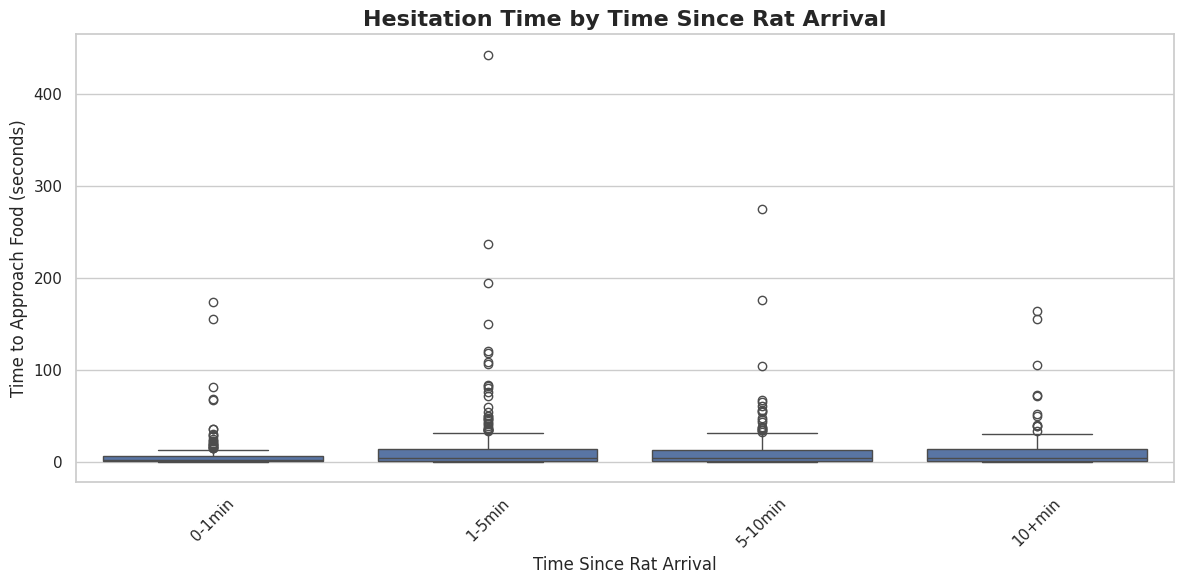

Group sizes - Immediate: 92, Non-immediate: 814
Mean hesitation - Immediate: 5.62s, Non-immediate: 12.41s

Mann-Whitney U Test Results:
U Statistic: 29365.5
P-value: 0.000659
 SIGNIFICANT: Bats show different hesitation behavior based on immediate rat presence

ANALYSIS 2: RISK BEHAVIOR BY TIME SINCE RAT ARRIVAL
Contingency Table:


,Risk-Avoidance,Risk-Taking
time_category,,
0-1min,79,75
1-5min,217,207
5-10min,99,102
10+min,63,64


<Figure size 1000x600 with 0 Axes>

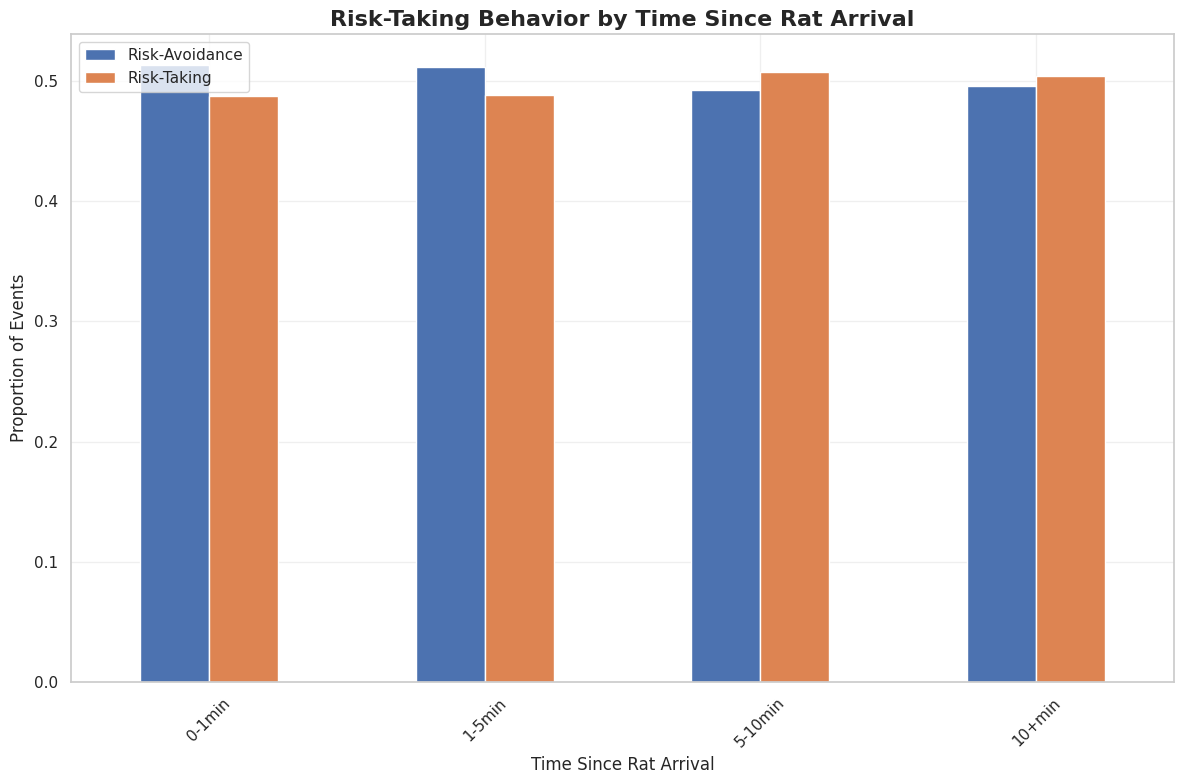

Chi-Squared Test Results:
Chi2 Statistic: 0.282
P-value: 0.963367
Degrees of freedom: 3
 NOT SIGNIFICANT: No statistical evidence of varying risk behavior

ADDITIONAL ANALYSIS: RISK VS REWARD
Risk Behavior vs Reward:


,No Reward,Reward
Risk-Avoidance,72,386
Risk-Taking,350,98


Success Rate by Risk Behavior:
Risk-Avoidance: 0.843
Risk-Taking: 0.219

SUMMARY (inline only, nothing exported)


,total_observations,immediate_rat_presence_count,immediate_rat_presence_percentage,avg_hesitation_immediate,avg_hesitation_non_immediate,risk_taking_rate,reward_rate
0,906,92,10.155,5.619,12.410,0.494,0.534


In [ ]:
# --- HIT140 Assessment 2: Investigation A Analysis ---
# --- Analysis of Bat Vigilance and Avoidance Behavior in the Presence of Rats ---

# 1. Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, chi2_contingency, pearsonr
import warnings
warnings.filterwarnings('ignore')

# Set visual style for plots (inline only)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# 2. Load the datasets
print("Loading datasets...")
df1 = pd.read_csv('dataset1.csv')   # Individual bat landings
df2 = pd.read_csv('dataset2.csv')   # 30-minute observation periods
print(" Datasets loaded successfully")
print(f"Dataset1 shape: {df1.shape}")
print(f"Dataset2 shape: {df2.shape}")

# 3. Data cleaning for dataset1
print("\n" + "="*50)
print("DATA CLEANING - dataset1")
print("="*50)

df1_clean = df1.copy()

# Convert time columns to datetime
print("Converting time columns...")
date_columns = ['start_time', 'rat_period_start', 'rat_period_end', 'sunset_time']
for col in date_columns:
    # Keep your original format; if parsing fails, values become NaT (fine for this analysis)
    df1_clean[col] = pd.to_datetime(df1_clean[col], format='%d/%m/%Y %H:%M', errors='coerce')

# Handle missing values on key vars
initial_size = df1_clean.shape[0]
df1_clean = df1_clean.dropna(subset=['bat_landing_to_food', 'risk', 'reward'])
print(f"Removed {initial_size - df1_clean.shape[0]} rows with missing critical values")

# Remove duplicates
initial_size = df1_clean.shape[0]
df1_clean = df1_clean.drop_duplicates()
print(f"Removed {initial_size - df1_clean.shape[0]} duplicate rows")

print(f"Final cleaned dataset size: {df1_clean.shape}")

# 4. CORRECTED Feature engineering
print("\n" + "="*50)
print("CORRECTED FEATURE ENGINEERING")
print("="*50)

# Ensure positive seconds
df1_clean['seconds_after_rat_arrival'] = df1_clean['seconds_after_rat_arrival'].abs()

# Immediate rat presence (≤ 30 seconds)
df1_clean['immediate_rat_presence'] = df1_clean['seconds_after_rat_arrival'] <= 30

# Time categories with proper bins
bins = [0, 60, 300, 600, 1000]  # 0-60s, 61-300s, 301-600s, 601-1000s
labels = ['0-1min', '1-5min', '5-10min', '10+min']
df1_clean['time_category'] = pd.cut(
    df1_clean['seconds_after_rat_arrival'],
    bins=bins, labels=labels, include_lowest=True
)

print("Features created:")
print(f"- immediate_rat_presence: {df1_clean['immediate_rat_presence'].value_counts().to_dict()}")
print(f"- time_category: {df1_clean['time_category'].value_counts().to_dict()}")

# Sample verification
print("\nSample data verification:")
display(df1_clean[['seconds_after_rat_arrival', 'immediate_rat_presence', 'time_category']].head(6))

# 5. Statistical Analysis: Vigilance (Hesitation Time)
print("\n" + "="*50)
print("ANALYSIS 1: VIGILANCE BY TIME SINCE RAT ARRIVAL")
print("="*50)

plt.figure(figsize=(12, 6))
sns.boxplot(x='time_category', y='bat_landing_to_food', data=df1_clean)
plt.title('Hesitation Time by Time Since Rat Arrival', fontsize=16, fontweight='bold')
plt.xlabel('Time Since Rat Arrival', fontsize=12)
plt.ylabel('Time to Approach Food (seconds)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()  # INLINE ONLY (no save)

# Compare immediate vs non-immediate presence
group_immediate = df1_clean[df1_clean['immediate_rat_presence'] == True]['bat_landing_to_food']
group_non_immediate = df1_clean[df1_clean['immediate_rat_presence'] == False]['bat_landing_to_food']

print(f"Group sizes - Immediate: {len(group_immediate)}, Non-immediate: {len(group_non_immediate)}")
print(f"Mean hesitation - Immediate: {group_immediate.mean():.2f}s, Non-immediate: {group_non_immediate.mean():.2f}s")

if len(group_immediate) > 0 and len(group_non_immediate) > 0:
    stat, p_value = mannwhitneyu(group_immediate, group_non_immediate, alternative='two-sided')
    print("\nMann-Whitney U Test Results:")
    print(f"U Statistic: {stat}")
    print(f"P-value: {p_value:.6f}")
    print(" SIGNIFICANT: Bats show different hesitation behavior based on immediate rat presence"
          if p_value < 0.05 else
          " NOT SIGNIFICANT: No statistical evidence of different hesitation behavior")
else:
    print("Insufficient data for statistical comparison")

# 6. Statistical Analysis: Avoidance (Risk Behavior)
print("\n" + "="*50)
print("ANALYSIS 2: RISK BEHAVIOR BY TIME SINCE RAT ARRIVAL")
print("="*50)

contingency_table = pd.crosstab(df1_clean['time_category'], df1_clean['risk'])
contingency_table.columns = ['Risk-Avoidance', 'Risk-Taking']

print("Contingency Table:")
display(contingency_table)

plt.figure(figsize=(10, 6))
risk_proportions = df1_clean.groupby('time_category')['risk'].value_counts(normalize=True).unstack()
risk_proportions.plot(kind='bar')
plt.title('Risk-Taking Behavior by Time Since Rat Arrival', fontsize=16, fontweight='bold')
plt.xlabel('Time Since Rat Arrival', fontsize=12)
plt.ylabel('Proportion of Events', fontsize=12)
plt.legend(['Risk-Avoidance', 'Risk-Taking'])
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()  # INLINE ONLY (no save)

# Chi-squared test
if len(contingency_table) > 1:
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print("Chi-Squared Test Results:")
    print(f"Chi2 Statistic: {chi2:.3f}")
    print(f"P-value: {p_value:.6f}")
    print(f"Degrees of freedom: {dof}")
    print(" SIGNIFICANT: Risk behavior varies with time since rat arrival"
          if p_value < 0.05 else
          " NOT SIGNIFICANT: No statistical evidence of varying risk behavior")
else:
    print("Insufficient categories for chi-squared test")

# 7. Additional analysis: Risk vs Reward
print("\n" + "="*50)
print("ADDITIONAL ANALYSIS: RISK VS REWARD")
print("="*50)

risk_reward_table = pd.crosstab(df1_clean['risk'], df1_clean['reward'])
risk_reward_table.columns = ['No Reward', 'Reward']
risk_reward_table.index = ['Risk-Avoidance', 'Risk-Taking']

print("Risk Behavior vs Reward:")
display(risk_reward_table)

reward_by_risk = df1_clean.groupby('risk')['reward'].mean()
print("Success Rate by Risk Behavior:")
print(f"Risk-Avoidance: {reward_by_risk.get(0, np.nan):.3f}")
print(f"Risk-Taking: {reward_by_risk.get(1, np.nan):.3f}")

# 8. Summary (INLINE ONLY — no file writes)
print("\n" + "="*50)
print("SUMMARY (inline only, nothing exported)")
print("="*50)

summary = {
    'total_observations': len(df1_clean),
    'immediate_rat_presence_count': int(df1_clean['immediate_rat_presence'].sum()),
    'immediate_rat_presence_percentage': float((df1_clean['immediate_rat_presence'].mean()) * 100),
    'avg_hesitation_immediate': float(group_immediate.mean() if len(group_immediate) > 0 else np.nan),
    'avg_hesitation_non_immediate': float(group_non_immediate.mean() if len(group_non_immediate) > 0 else np.nan),
    'risk_taking_rate': float(df1_clean['risk'].mean()),
    'reward_rate': float(df1_clean['reward'].mean())
}
pd.options.display.float_format = '{:,.3f}'.format
display(pd.DataFrame([summary]))



                             OLS Regression Results                            
Dep. Variable:     bat_landing_to_food   R-squared:                       0.011
Model:                             OLS   Adj. R-squared:                  0.005
Method:                  Least Squares   F-statistic:                     1.713
Date:                 Wed, 08 Oct 2025   Prob (F-statistic):              0.115
Time:                         05:16:24   Log-Likelihood:                -4287.8
No. Observations:                  906   AIC:                             8590.
Df Residuals:                      899   BIC:                             8623.
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

<Figure size 1200x800 with 0 Axes>

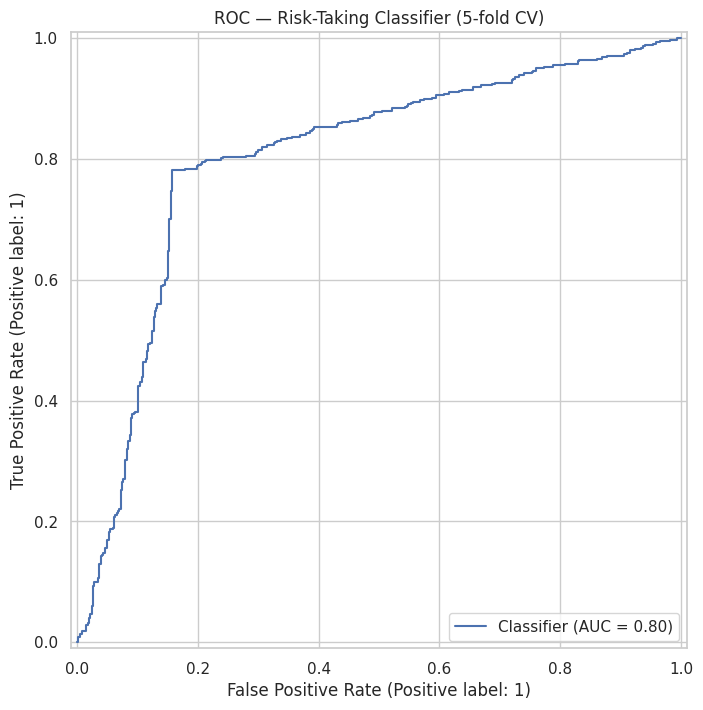

In [16]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix

# Natural cubic spline on seconds_after_rat_arrival (3 df as a start)
df1_spline = df1_clean.copy()
df1_spline['reward'] = pd.to_numeric(df1_spline['reward'], errors='coerce')
design = dmatrix("bs(seconds_after_rat_arrival, df=3, include_intercept=False)",
                 df1_spline, return_type='dataframe')
X = pd.concat([design, df1_spline[['season','hours_after_sunset','reward']]], axis=1)
X = sm.add_constant(X)
y = df1_spline['bat_landing_to_food']

spline_mod = sm.OLS(y, X, missing='drop').fit()
print(spline_mod.summary())

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, RocCurveDisplay, brier_score_loss
import matplotlib.pyplot as plt

X = df1_clean[['seconds_after_rat_arrival','hours_after_sunset','season','reward']].fillna(0)
y = df1_clean['risk'].astype(int)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logit', LogisticRegression(max_iter=200, penalty='l2', solver='lbfgs'))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
probs = cross_val_predict(pipe, X, y, cv=cv, method='predict_proba')[:,1]
auc = roc_auc_score(y, probs)
print(f"AUC (5-fold CV): {auc:.3f}")
print(f"Brier score: {brier_score_loss(y, probs):.3f}")

# ROC curve
plt.figure()
RocCurveDisplay.from_predictions(y, probs)
plt.title('ROC — Risk-Taking Classifier (5-fold CV)')
plt.show()



,threshold_s,n_immediate,n_non_immediate,U,p_value,mean_immediate,mean_non_immediate
0,10,34,872,"12,825.000",0.181,6.064,11.941
1,20,63,843,"20,211.500",0.001,5.695,12.171
2,30,92,814,"29,365.500",0.001,5.619,12.410
3,60,154,752,"47,787.000",0.001,8.464,12.388
4,120,296,610,"80,497.500",0.008,11.086,12.029


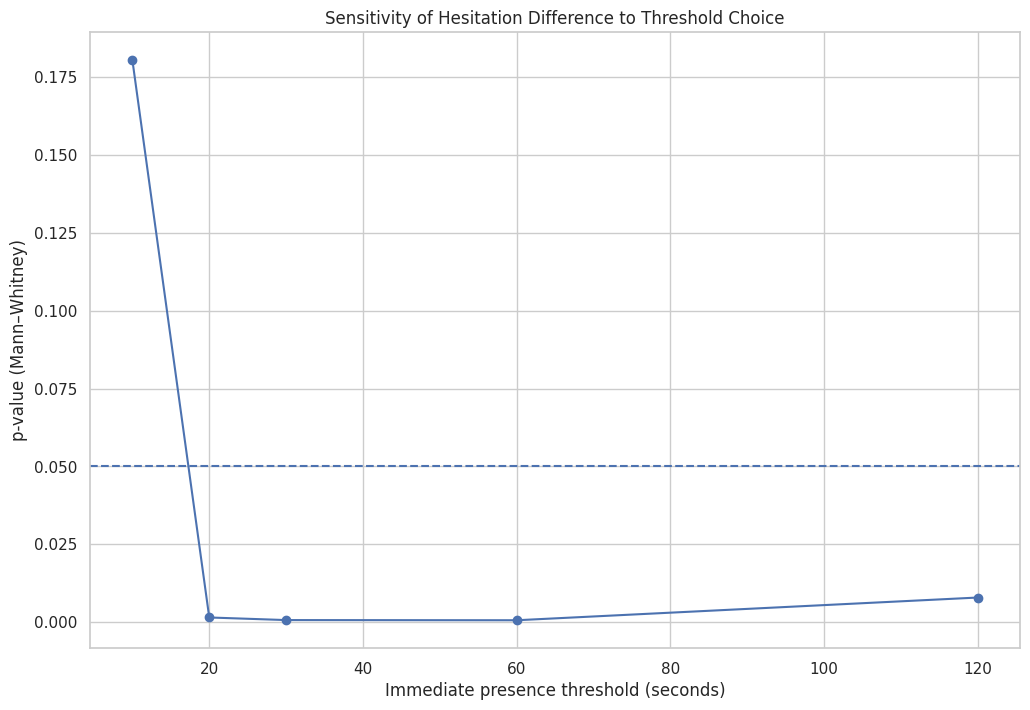

Indirect effect (risk → reward → hesitation): -28.309  |  95% CI (np.float64(-55.14641431282862), np.float64(-3.8276033176272457))


In [17]:
from scipy.stats import rankdata

def sweep_thresholds(ths=(10, 20, 30, 60, 120)):
    rows = []
    for th in ths:
        flag = df1_clean['seconds_after_rat_arrival'] <= th
        g1 = df1_clean.loc[flag, 'bat_landing_to_food'].dropna()
        g0 = df1_clean.loc[~flag, 'bat_landing_to_food'].dropna()
        if len(g1) > 5 and len(g0) > 5:
            U, p = mannwhitneyu(g1, g0, alternative='two-sided')
            rows.append({'threshold_s': th, 'n_immediate': len(g1),
                         'n_non_immediate': len(g0), 'U': U, 'p_value': p,
                         'mean_immediate': g1.mean(), 'mean_non_immediate': g0.mean()})
    return pd.DataFrame(rows)

sweep_df = sweep_thresholds()
display(sweep_df)
plt.figure()
plt.plot(sweep_df['threshold_s'], sweep_df['p_value'], marker='o')
plt.axhline(0.05, ls='--')
plt.xlabel('Immediate presence threshold (seconds)')
plt.ylabel('p-value (Mann–Whitney)')
plt.title('Sensitivity of Hesitation Difference to Threshold Choice')
plt.show()

rng = np.random.default_rng(42)
dfm = df1_clean[['risk','reward','bat_landing_to_food','seconds_after_rat_arrival',
                 'season','hours_after_sunset']].dropna().copy()

# Model A: reward ~ risk + covariates (logit)
mA = smf.logit("reward ~ risk + seconds_after_rat_arrival + season + hours_after_sunset", data=dfm).fit(disp=False)
a = mA.params['risk']

# Model B: hesitation ~ risk + reward + covariates (OLS)
mB = smf.ols("bat_landing_to_food ~ risk + reward + seconds_after_rat_arrival + season + hours_after_sunset",
             data=dfm).fit()
b = mB.params['reward']

indirect = a * b

# Bootstrap CI for indirect effect
B = 1000
boot = []
for _ in range(B):
    samp = dfm.sample(frac=1, replace=True, random_state=rng.integers(1e9))
    try:
        a_b = smf.logit("reward ~ risk + seconds_after_rat_arrival + season + hours_after_sunset",
                        data=samp).fit(disp=False).params['risk']
        b_b = smf.ols("bat_landing_to_food ~ risk + reward + seconds_after_rat_arrival + season + hours_after_sunset",
                      data=samp).fit().params['reward']
        boot.append(a_b * b_b)
    except Exception:
        continue

ci = (np.percentile(boot, 2.5), np.percentile(boot, 97.5))
print(f"Indirect effect (risk → reward → hesitation): {indirect:.3f}  |  95% CI {ci}")


=== Table 3. Seasonal summary (Dataset 1: behavioural) ===


,n,risk_rate,reward_rate,hesitation_mean,hesitation_median,immediate_rat_presence_rate
season_label,,,,,,
Spring,756,0.481,0.567,12.846,4.000,0.091
Winter,151,0.563,0.364,6.040,2.000,0.152



=== Table 4. Seasonal summary (Dataset 2: contextual counts) ===


,rat_arrival_number,rat_minutes,bat_landing_number,food_availability,hours_after_sunset
season_label,,,,,
Spring,0.596,3.105,28.658,2.529,5.031
Winter,0.239,0.469,36.758,2.343,5.566



=== Seasonal tests (Winter vs Spring) ===
Hesitation (Mann–Whitney): U=46006.5, p=1.577e-04 | Winter mean=6.04s, Spring mean=12.85s
Risk × Season (χ²): χ²=3.02, df=1, p=8.219e-02


risk,0,1
season_label,,
Spring,392,364
Winter,66,85


Reward × Season (χ²): χ²=20.08, df=1, p=7.436e-06


reward,0,1
season_label,,
Spring,327,429
Winter,96,55


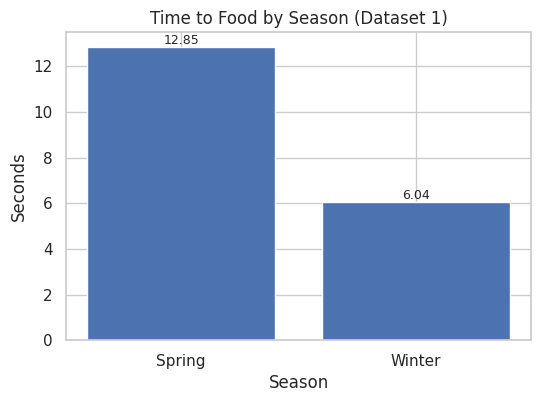

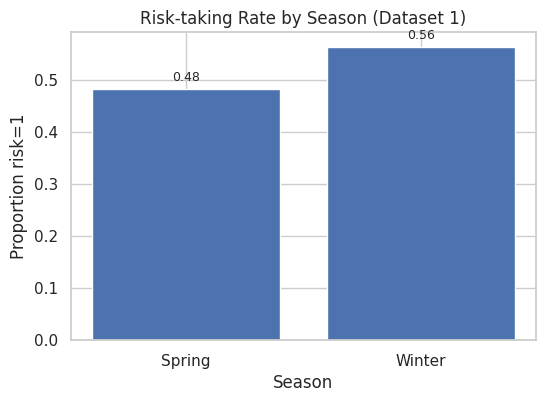

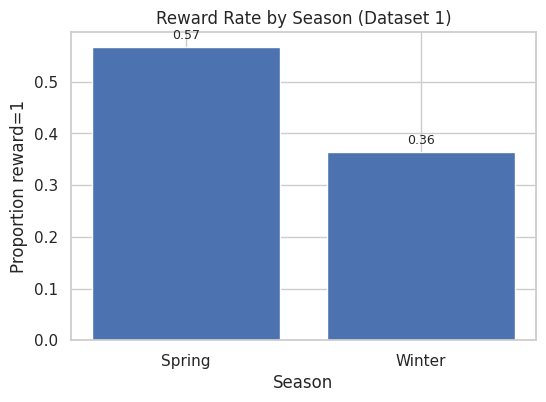

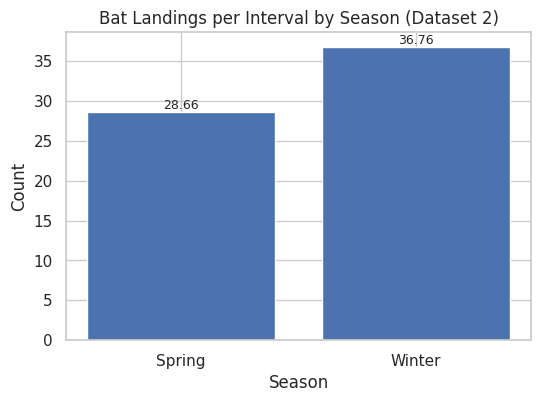

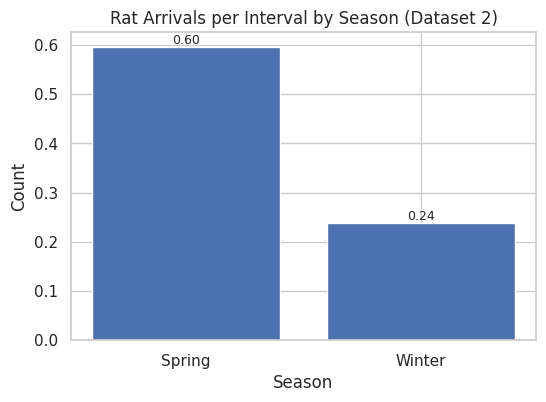

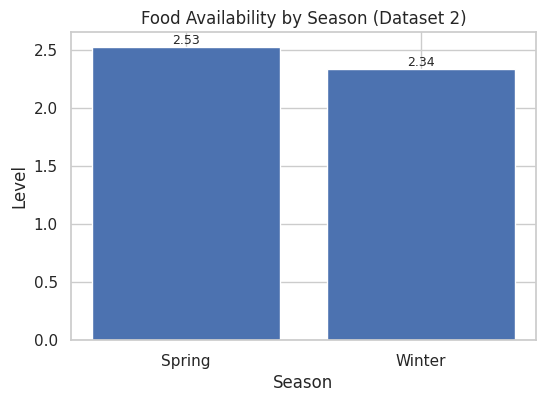

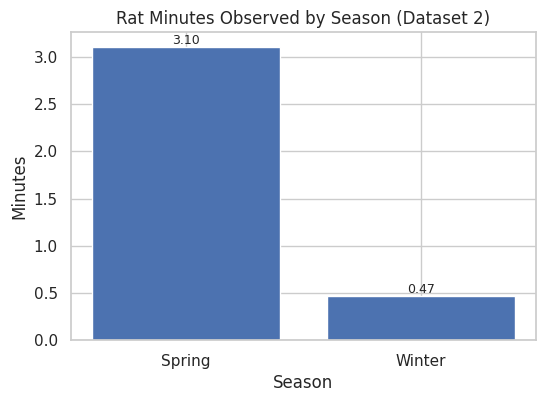

In [18]:
# --- HIT140 Assessment 3: Investigation B ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, chi2_contingency

# Styling (inline only)
sns.set(style="whitegrid")

# 1) Load data (paths as per your Colab runtime)
df1 = pd.read_csv('/content/dataset1.csv')
df2 = pd.read_csv('/content/dataset2.csv')

# 2) Minimal cleaning & helpers
df1.columns = df1.columns.str.strip().str.lower().str.replace(" ", "_")
df2.columns = df2.columns.str.strip().str.lower().str.replace(" ", "_")

for col in ['bat_landing_to_food','risk','reward','hours_after_sunset','seconds_after_rat_arrival']:
    if col in df1.columns:
        df1[col] = pd.to_numeric(df1[col], errors='coerce')

for col in ['bat_landing_number','rat_arrival_number','rat_minutes','food_availability','hours_after_sunset','month']:
    if col in df2.columns:
        df2[col] = pd.to_numeric(df2[col], errors='coerce')

# Immediate rat presence flag (optional metric)
if 'seconds_after_rat_arrival' in df1.columns:
    df1['immediate_rat_presence'] = df1['seconds_after_rat_arrival'].abs() <= 30

# Season mapping
season_map = {0: 'Winter', 1: 'Spring'}
if 'season' in df1.columns:
    df1['season_label'] = df1['season'].map(season_map)

# If df2 has no season, derive from df1’s (month → most common season in df1)
if 'season' in df2.columns:
    df2['season_label'] = df2['season'].map(season_map)
else:
    if {'month','season_label'}.issubset(df1.columns):
        month_to_season = (df1.dropna(subset=['month','season_label'])
                             .groupby('month')['season_label']
                             .agg(lambda s: s.mode().iloc[0] if not s.empty else np.nan))
        df2['season_label'] = df2['month'].map(month_to_season)

# Keep Winter/Spring only (as per brief)
df1 = df1[df1['season_label'].isin(['Winter','Spring'])]
df2 = df2[df2['season_label'].isin(['Winter','Spring'])]

# ---------- SUMMARY TABLES (printed inline) ----------
print("=== Table 3. Seasonal summary (Dataset 1: behavioural) ===")
tbl3 = (df1.groupby('season_label')
          .agg(n=('season_label','size'),
               risk_rate=('risk','mean'),
               reward_rate=('reward','mean'),
               hesitation_mean=('bat_landing_to_food','mean'),
               hesitation_median=('bat_landing_to_food','median'),
               immediate_rat_presence_rate=('immediate_rat_presence','mean'))
          .round(3))
display(tbl3)

print("\n=== Table 4. Seasonal summary (Dataset 2: contextual counts) ===")
have = [c for c in ['rat_arrival_number','rat_minutes','bat_landing_number','food_availability','hours_after_sunset']
        if c in df2.columns]
tbl4 = df2.groupby('season_label')[have].mean().round(3)
display(tbl4)

# ---------- INFERENTIAL TESTS (printed inline) ----------
print("\n=== Seasonal tests (Winter vs Spring) ===")

# Hesitation time
if 'bat_landing_to_food' in df1.columns:
    w = df1.loc[df1['season_label']=='Winter', 'bat_landing_to_food'].dropna()
    s = df1.loc[df1['season_label']=='Spring', 'bat_landing_to_food'].dropna()
    if len(w) > 0 and len(s) > 0:
        u, p = mannwhitneyu(w, s, alternative='two-sided')
        print(f"Hesitation (Mann–Whitney): U={u:.1f}, p={p:.3e} | "
              f"Winter mean={w.mean():.2f}s, Spring mean={s.mean():.2f}s")

# Risk rate chi-square
ct_risk = pd.crosstab(df1['season_label'], df1['risk'])
if ct_risk.shape == (2,2):
    chi2, p, dof, _ = chi2_contingency(ct_risk)
    print(f"Risk × Season (χ²): χ²={chi2:.2f}, df={dof}, p={p:.3e}")
    display(ct_risk)

# Reward rate chi-square
ct_reward = pd.crosstab(df1['season_label'], df1['reward'])
if ct_reward.shape == (2,2):
    chi2, p, dof, _ = chi2_contingency(ct_reward)
    print(f"Reward × Season (χ²): χ²={chi2:.2f}, df={dof}, p={p:.3e}")
    display(ct_reward)

# ---------- INLINE PLOTS (NO FILES SAVED) ----------
def bar_prop(df, col, title, ylabel):
    prop = df.groupby('season_label')[col].mean()
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(prop.index, prop.values)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Season")
    for i, v in enumerate(prop.values):
        ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=9)
    plt.show()

def bar_mean(df, col, title, ylabel):
    means = df.groupby('season_label')[col].mean()
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(means.index, means.values)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Season")
    for i, v in enumerate(means.values):
        ax.text(i, v, f"{v:.2f}", ha='center', va='bottom', fontsize=9)
    plt.show()

# Figure 1. Hesitation (time to food) by season (Dataset 1)
if 'bat_landing_to_food' in df1.columns:
    bar_mean(df1, 'bat_landing_to_food',
             "Time to Food by Season (Dataset 1)", "Seconds")

# Figure 2. Risk-taking rate by season (Dataset 1)
if 'risk' in df1.columns:
    bar_prop(df1, 'risk',
             "Risk-taking Rate by Season (Dataset 1)", "Proportion risk=1")

# Figure 3. Reward rate by season (Dataset 1)
if 'reward' in df1.columns:
    bar_prop(df1, 'reward',
             "Reward Rate by Season (Dataset 1)", "Proportion reward=1")

# Figure 4–7. Dataset 2 counts by season
for col, title, ylab in [
    ('bat_landing_number', "Bat Landings per Interval by Season (Dataset 2)", "Count"),
    ('rat_arrival_number', "Rat Arrivals per Interval by Season (Dataset 2)", "Count"),
    ('food_availability', "Food Availability by Season (Dataset 2)", "Level"),
    ('rat_minutes',       "Rat Minutes Observed by Season (Dataset 2)", "Minutes"),
]:
    if col in df2.columns:
        bar_mean(df2, col, title, ylab)


=== Effect sizes with 95% bootstrap CIs ===
Risk proportion Winter=0.563 (95% CI 0.483–0.642); Spring=0.481 (95% CI 0.447–0.519); Diff (S−W)=-0.081; Cohen's h=-0.163
Hesitation mean Winter=6.04s (95% CI 4.23–8.58); Spring=12.85s (95% CI 10.87–14.94); Mann–Whitney U=46006.5, p=1.577e-04, rank-biserial r=0.194

=== Quantile regression for Time-to-food (τ=0.25,0.50,0.75) ===

τ = 0.25


<class 'statsmodels.iolib.summary.Summary'>
"""
                          QuantReg Regression Results                          
===============================================================================
Dep. Variable:     bat_landing_to_food   Pseudo R-squared:           -1.201e-08
Model:                        QuantReg   Bandwidth:                       3.483
Method:                  Least Squares   Sparsity:                        10.32
Date:                 Wed, 08 Oct 2025   No. Observations:                  907
Time:                         05:16:52   Df Residuals:                      903
                                         Df Model:                            3
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.0000      0.567      1.764      0.078      -0.113       2.113
season              3.152e-06      0.429   7.34e-06      1.000      -0.842       0.842
hours_after_sunset  2.855e-08      0.069   4.16e-07      1.000      -0.135       0.135
reward             -2.846e-06      0.307  -9.27e-06      1.000      -0.603       0.603
======================================================================================
"""


τ = 0.50


<class 'statsmodels.iolib.summary.Summary'>
"""
                          QuantReg Regression Results                          
===============================================================================
Dep. Variable:     bat_landing_to_food   Pseudo R-squared:             0.008021
Model:                        QuantReg   Bandwidth:                       3.796
Method:                  Least Squares   Sparsity:                        13.42
Date:                 Wed, 08 Oct 2025   No. Observations:                  907
Time:                         05:16:52   Df Residuals:                      903
                                         Df Model:                            3
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.0000      0.762      3.937      0.000       1.505       4.495
season                 2.0000      0.605      3.305      0.001       0.812       3.188
hours_after_sunset  1.946e-07      0.092    2.1e-06      1.000      -0.181       0.181
reward                -1.0000      0.452     -2.210      0.027      -1.888      -0.112
======================================================================================
"""


τ = 0.75


<class 'statsmodels.iolib.summary.Summary'>
"""
                          QuantReg Regression Results                          
===============================================================================
Dep. Variable:     bat_landing_to_food   Pseudo R-squared:              0.01679
Model:                        QuantReg   Bandwidth:                       3.553
Method:                  Least Squares   Sparsity:                        50.49
Date:                 Wed, 08 Oct 2025   No. Observations:                  907
Time:                         05:16:52   Df Residuals:                      903
                                         Df Model:                            3
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.6261      2.418      3.567      0.000       3.880      13.372
season                 7.0339      1.991      3.533      0.000       3.127      10.941
hours_after_sunset    -0.2096      0.295     -0.710      0.478      -0.789       0.370
reward                -2.6417      1.491     -1.772      0.077      -5.568       0.285
======================================================================================
"""

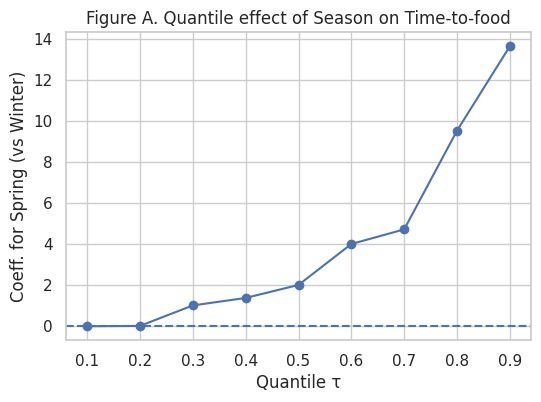


=== Seasonal patterns by time-of-night bins ===

Table: Risk proportion by time-of-night × season


season_label,Spring,Winter
night_bin,,
≤2h,0.527,0.500
2–4h,0.497,0.629
4–6h,0.530,0.676
6–8h,0.427,0.361
>8h,0.453,0.625


Table: Median hesitation (s) by time-of-night × season


season_label,Spring,Winter
night_bin,,
≤2h,2.000,3.500
2–4h,5.000,2.000
4–6h,5.000,2.000
6–8h,4.000,2.000
>8h,4.000,2.500


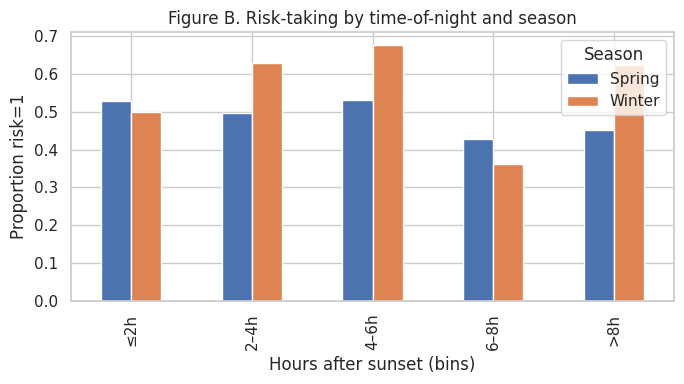


=== Partial Spearman (residualized) for Dataset 2 ===
Partial Spearman (controlling for hours_after_sunset): ρ=-0.120, p=0.0000

=== Interaction visual (means) ===


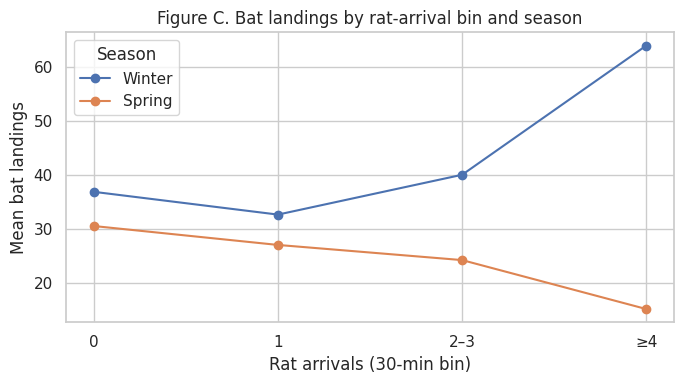

In [19]:
# --- HIT140 Assessment 3: Investigation B (Further Analysis) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
sns.set(style="whitegrid")

# --- Assumes df1 and df2 from your previous cells (already cleaned & have 'season_label') ---
assert {'Winter','Spring'}.issubset(set(df1['season_label'].dropna().unique())), "df1['season_label'] missing"
assert {'Winter','Spring'}.issubset(set(df2['season_label'].dropna().unique())), "df2['season_label'] missing"

# Helper: bootstrap CI for a scalar statistic
def bootstrap_ci(x, stat_func=np.mean, nboot=5000, alpha=0.05, random_state=42):
    rng = np.random.default_rng(random_state)
    x = np.asarray(pd.Series(x).dropna().values)
    boots = [stat_func(rng.choice(x, size=x.size, replace=True)) for _ in range(nboot)]
    lo, hi = np.quantile(boots, [alpha/2, 1-alpha/2])
    return stat_func(x), (lo, hi)

# 1) EFFECT SIZES + BOOTSTRAPPED CONFIDENCE INTERVALS

print("=== Effect sizes with 95% bootstrap CIs ===")

# 1a) Risk-taking proportion Winter vs Spring
risk_w = df1.loc[df1['season_label']=='Winter', 'risk'].dropna().astype(int)
risk_s = df1.loc[df1['season_label']=='Spring', 'risk'].dropna().astype(int)
p_w, ci_w = bootstrap_ci(risk_w, stat_func=np.mean)
p_s, ci_s = bootstrap_ci(risk_s, stat_func=np.mean)
risk_diff = p_s - p_w

# Cohen's h for proportions
def cohens_h(p1, p2):
    return 2*np.arcsin(np.sqrt(p2)) - 2*np.arcsin(np.sqrt(p1))
h = cohens_h(p_w, p_s)

print(f"Risk proportion Winter={p_w:.3f} (95% CI {ci_w[0]:.3f}–{ci_w[1]:.3f}); "
      f"Spring={p_s:.3f} (95% CI {ci_s[0]:.3f}–{ci_s[1]:.3f}); "
      f"Diff (S−W)={risk_diff:.3f}; Cohen's h={h:.3f}")

# 1b) Hesitation (bat_landing_to_food) Winter vs Spring
hes_w = df1.loc[df1['season_label']=='Winter', 'bat_landing_to_food']
hes_s = df1.loc[df1['season_label']=='Spring', 'bat_landing_to_food']
m_w, ci_mw = bootstrap_ci(hes_w)
m_s, ci_ms = bootstrap_ci(hes_s)

# Mann–Whitney effect size: rank-biserial correlation r_rb = 1 - 2*U/(n1*n2)
U, p = stats.mannwhitneyu(hes_w, hes_s, alternative='two-sided')
n1, n2 = len(hes_w), len(hes_s)
r_rb = 1 - 2*U/(n1*n2)

print(f"Hesitation mean Winter={m_w:.2f}s (95% CI {ci_mw[0]:.2f}–{ci_mw[1]:.2f}); "
      f"Spring={m_s:.2f}s (95% CI {ci_ms[0]:.2f}–{ci_ms[1]:.2f}); "
      f"Mann–Whitney U={U:.1f}, p={p:.3e}, rank-biserial r={r_rb:.3f}")

# 2) QUANTILE REGRESSION (25th, 50th, 75th) for hesitation

print("\n=== Quantile regression for Time-to-food (τ=0.25,0.50,0.75) ===")
qr_df = df1[['bat_landing_to_food','season_label','hours_after_sunset','reward']].dropna().copy()
qr_df['season'] = (qr_df['season_label']=='Spring').astype(int)  # Spring=1, Winter=0
for q in [0.25, 0.50, 0.75]:
    qr = smf.quantreg('bat_landing_to_food ~ season + hours_after_sunset + reward', data=qr_df).fit(q=q)
    print(f"\nτ = {q:.2f}")
    display(qr.summary())

# Visual: coefficients over quantiles (season only)
taus = np.linspace(0.1, 0.9, 9)
betas = []
for q in taus:
    m = smf.quantreg('bat_landing_to_food ~ season + hours_after_sunset + reward', data=qr_df).fit(q=q)
    betas.append(m.params['season'])
plt.figure(figsize=(6,4))
plt.plot(taus, betas, marker='o')
plt.xlabel('Quantile τ')
plt.ylabel('Coeff. for Spring (vs Winter)')
plt.title('Figure A. Quantile effect of Season on Time-to-food')
plt.axhline(0, ls='--')
plt.show()


# 3) TIME-OF-NIGHT STRATIFICATION

print("\n=== Seasonal patterns by time-of-night bins ===")
bins = [-np.inf, 2, 4, 6, 8, np.inf]
labels = ['≤2h','2–4h','4–6h','6–8h','>8h']
df1['night_bin'] = pd.cut(df1['hours_after_sunset'], bins=bins, labels=labels)

# Risk rate by season × night bin
pivot_risk = (df1.dropna(subset=['night_bin'])
                .groupby(['night_bin','season_label'])['risk']
                .mean().unstack())
print("\nTable: Risk proportion by time-of-night × season")
display(pivot_risk.round(3))

pivot_hes = (df1.dropna(subset=['night_bin'])
               .groupby(['night_bin','season_label'])['bat_landing_to_food']
               .median().unstack())
print("Table: Median hesitation (s) by time-of-night × season")
display(pivot_hes.round(2))

# Plot risk by bins
pivot_risk.plot(kind='bar', figsize=(7,4))
plt.title('Figure B. Risk-taking by time-of-night and season')
plt.ylabel('Proportion risk=1'); plt.xlabel('Hours after sunset (bins)')
plt.legend(title='Season')
plt.tight_layout(); plt.show()


# 4) PARTIAL SPEARMAN: BAT LANDINGS ~ RAT ARRIVALS | HOURS_AFTER_SUNSET

print("\n=== Partial Spearman (residualized) for Dataset 2 ===")
d2 = df2[['bat_landing_number','rat_arrival_number','hours_after_sunset']].dropna().copy()

# Residualize both counts w.r.t hours_after_sunset via linear regression (rank-based alt. would be similar)
for col in ['bat_landing_number','rat_arrival_number']:
    X = sm.add_constant(d2['hours_after_sunset'])
    res = sm.OLS(d2[col], X).fit().resid
    d2[f'{col}_resid'] = res

rho, pval = stats.spearmanr(d2['bat_landing_number_resid'], d2['rat_arrival_number_resid'])
print(f"Partial Spearman (controlling for hours_after_sunset): ρ={rho:.3f}, p={pval:.4f}")


# 5) INTERACTION PLOT (SEASON × RAT ARRIVALS → BAT LANDINGS)

print("\n=== Interaction visual (means) ===")
df2['rat_bin'] = pd.cut(df2['rat_arrival_number'],
                        bins=[-0.5, 0.5, 1.5, 3.5, np.inf],
                        labels=['0','1','2–3','≥4'])
means = df2.groupby(['season_label','rat_bin'])['bat_landing_number'].mean().reset_index()

plt.figure(figsize=(7,4))
for s in ['Winter','Spring']:
    sub = means[means['season_label']==s]
    plt.plot(sub['rat_bin'], sub['bat_landing_number'], marker='o', label=s)
plt.title('Figure C. Bat landings by rat-arrival bin and season')
plt.xlabel('Rat arrivals (30-min bin)'); plt.ylabel('Mean bat landings')
plt.legend(title='Season'); plt.tight_layout(); plt.show()
